# Complete Transformer Architecture with Mixture of Experts

This notebook demonstrates a complete Transformer architecture with:
1. Input embeddings and positional encoding
2. Multi-head attention mechanism
3. Mixture of Experts (MoE) feed-forward network
4. Residual connections and layer normalization
5. Complete transformer block
6. Practical sequence modeling example

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Positional Encoding

Positional encodings add information about the position of tokens in a sequence.
We use sinusoidal functions:

$$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d_{model}})$$

Input shape: torch.Size([2, 50, 64])
Output shape: torch.Size([2, 50, 64])


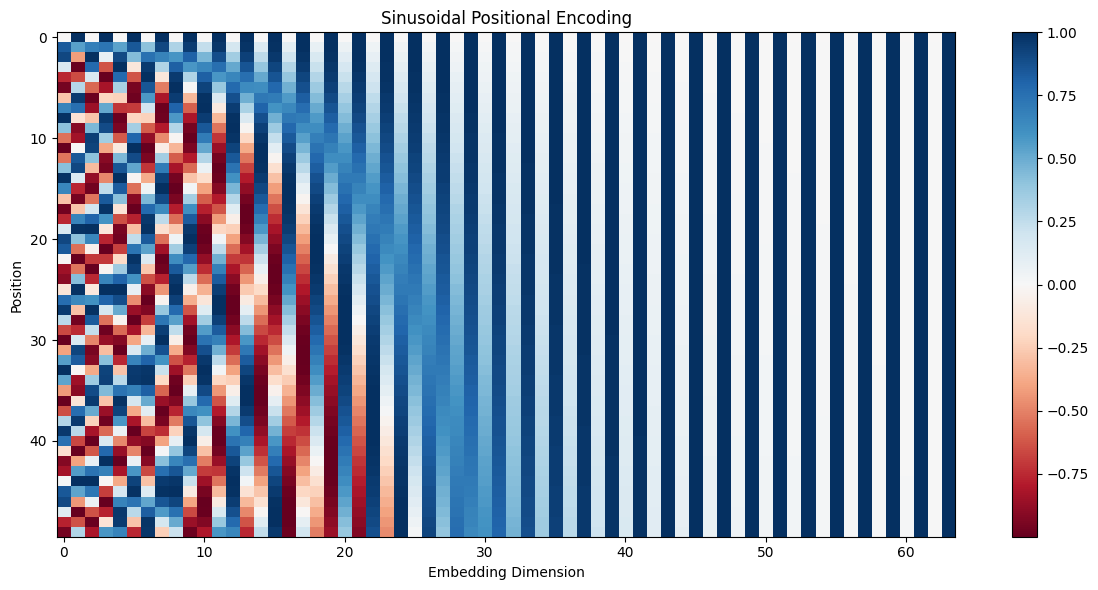

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding for transformers.
    
    Args:
        d_model: Model dimension
        max_len: Maximum sequence length
        dropout: Dropout probability
    """
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # https://discuss.pytorch.org/t/first-logarithm-and-then-exponential-whats-the-reason/153137
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # Performance optimization but results in same component
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        
        # Register as buffer (not a parameter)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Add positional encoding to input.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
        
        Returns:
            Tensor with positional encoding added
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Test positional encoding
d_model = 64
seq_len = 50
batch_size = 2

pos_encoder = PositionalEncoding(d_model)
x = torch.randn(batch_size, seq_len, d_model)
x_with_pos = pos_encoder(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {x_with_pos.shape}")

# Visualize positional encoding
plt.figure(figsize=(12, 6))
plt.imshow(pos_encoder.pe[0, :seq_len, :].cpu().numpy(), aspect='auto', cmap='RdBu')
plt.colorbar()
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.title('Sinusoidal Positional Encoding')
plt.tight_layout()
plt.show()

## 3. Multi-Head Attention

Multi-head attention allows the model to attend to information from different representation subspaces.

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$
$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

In [3]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention mechanism.
    
    Args:
        d_model: Model dimension
        num_heads: Number of attention heads
        dropout: Dropout probability
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear projections
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Compute scaled dot-product attention.
        
        Args:
            Q: Query tensor (batch_size, num_heads, seq_len, d_k)
            K: Key tensor (batch_size, num_heads, seq_len, d_k)
            V: Value tensor (batch_size, num_heads, seq_len, d_k)
            mask: Optional mask tensor
        """
        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        output = torch.matmul(attention_weights, V)
        
        return output, attention_weights
    
    def forward(self, query, key, value, mask=None):
        """
        Forward pass of multi-head attention.
        
        Args:
            query: Query tensor (batch_size, seq_len, d_model)
            key: Key tensor (batch_size, seq_len, d_model)
            value: Value tensor (batch_size, seq_len, d_model)
            mask: Optional mask tensor
        
        Returns:
            output: Attention output (batch_size, seq_len, d_model)
            attention_weights: Attention weights for visualization
        """
        batch_size = query.size(0)
        
        # Linear projections and reshape for multi-head
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Apply attention
        x, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Concatenate heads
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        # Final linear projection
        output = self.W_o(x)
        
        return output, attention_weights

# Test multi-head attention
d_model = 64
num_heads = 8
seq_len = 10
batch_size = 2

mha = MultiHeadAttention(d_model, num_heads)
x = torch.randn(batch_size, seq_len, d_model)
output, attention_weights = mha(x, x, x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"Number of parameters: {sum(p.numel() for p in mha.parameters()):,}")

Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])
Attention weights shape: torch.Size([2, 8, 10, 10])
Number of parameters: 16,640


## 4. Mixture of Experts Feed-Forward Network

Instead of a standard feed-forward network, we use a Mixture of Experts layer
that routes tokens to specialized expert networks.

In [4]:
class Expert(nn.Module):
    """Single expert network."""
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class GatingNetwork(nn.Module):
    """Gating network for routing tokens to experts."""
    def __init__(self, d_model, num_experts):
        super(GatingNetwork, self).__init__()
        self.gate = nn.Linear(d_model, num_experts)
    
    def forward(self, x):
        return self.gate(x)

class MixtureOfExpertsFFN(nn.Module):
    """
    Mixture of Experts Feed-Forward Network.
    
    Args:
        d_model: Model dimension
        d_ff: Feed-forward dimension
        num_experts: Number of expert networks
        top_k: Number of experts to use per token
        dropout: Dropout probability
    """
    def __init__(self, d_model, d_ff, num_experts=8, top_k=2, dropout=0.1):
        super(MixtureOfExpertsFFN, self).__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.d_model = d_model
        
        # Create expert networks
        self.experts = nn.ModuleList([
            Expert(d_model, d_ff, dropout) for _ in range(num_experts)
        ])
        
        # Gating network
        self.gate = GatingNetwork(d_model, num_experts)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        Forward pass through MoE layer.
        
        Args:
            x: Input tensor (batch_size, seq_len, d_model)
        
        Returns:
            output: Output tensor (batch_size, seq_len, d_model)
            aux_loss: Load balancing loss
        """
        batch_size, seq_len, d_model = x.shape
        
        # Compute gate logits
        gate_logits = self.gate(x)  # (batch_size, seq_len, num_experts)
        gate_probs = F.softmax(gate_logits, dim=-1)
        
        # Select top-k experts
        top_k_probs, top_k_indices = torch.topk(gate_probs, self.top_k, dim=-1)
        top_k_probs = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True)
        
        # Initialize output
        output = torch.zeros_like(x)
        
        # Process through selected experts
        for i, expert in enumerate(self.experts):
            # Get expert output
            expert_output = expert(x)
            
            # Get weights for this expert
            expert_weights = torch.where(
                top_k_indices == i,
                top_k_probs,
                torch.zeros_like(top_k_probs)
            ).sum(dim=-1, keepdim=True)
            
            # Add weighted expert output
            output += expert_weights * expert_output
        
        # Compute load balancing loss
        expert_usage = torch.zeros(self.num_experts, device=x.device)
        for i in range(self.num_experts):
            expert_usage[i] = (top_k_indices == i).float().mean()
        aux_loss = self.num_experts * (expert_usage ** 2).sum()
        
        output = self.dropout(output)
        return output, aux_loss

# Test MoE FFN
moe_ffn = MixtureOfExpertsFFN(d_model=64, d_ff=256, num_experts=4, top_k=2)
x = torch.randn(2, 10, 64)
output, aux_loss = moe_ffn(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Auxiliary loss: {aux_loss.item():.4f}")
print(f"Number of parameters: {sum(p.numel() for p in moe_ffn.parameters()):,}")

Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])
Auxiliary loss: 1.1050
Number of parameters: 132,612


## 5. Transformer Block with MoE

A complete transformer block combining:
- Multi-head self-attention
- Mixture of Experts feed-forward network
- Residual connections
- Layer normalization

In [5]:
class TransformerBlock(nn.Module):
    """
    Transformer block with multi-head attention and MoE feed-forward.
    
    Args:
        d_model: Model dimension
        num_heads: Number of attention heads
        d_ff: Feed-forward dimension
        num_experts: Number of expert networks
        top_k: Number of experts per token
        dropout: Dropout probability
    """
    def __init__(self, d_model, num_heads, d_ff, num_experts=8, top_k=2, dropout=0.1):
        super(TransformerBlock, self).__init__()
        
        # Multi-head attention
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        
        # MoE feed-forward network
        self.moe_ffn = MixtureOfExpertsFFN(d_model, d_ff, num_experts, top_k, dropout)
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        """
        Forward pass through transformer block.
        
        Args:
            x: Input tensor (batch_size, seq_len, d_model)
            mask: Optional attention mask
        
        Returns:
            output: Output tensor (batch_size, seq_len, d_model)
            attention_weights: Attention weights for visualization
            aux_loss: Load balancing loss from MoE
        """
        # Multi-head attention with residual connection and layer norm
        attn_output, attention_weights = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # MoE feed-forward with residual connection and layer norm
        moe_output, aux_loss = self.moe_ffn(x)
        x = self.norm2(x + moe_output)
        
        return x, attention_weights, aux_loss

# Test transformer block
transformer_block = TransformerBlock(
    d_model=64,
    num_heads=8,
    d_ff=256,
    num_experts=4,
    top_k=2
)

x = torch.randn(2, 10, 64)
output, attention_weights, aux_loss = transformer_block(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"Auxiliary loss: {aux_loss.item():.4f}")
print(f"Number of parameters: {sum(p.numel() for p in transformer_block.parameters()):,}")

Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])
Attention weights shape: torch.Size([2, 8, 10, 10])
Auxiliary loss: 1.1050
Number of parameters: 149,508


## 6. Complete Transformer Model

Stack multiple transformer blocks to create a complete model with:
- Token embeddings
- Positional encoding
- Multiple transformer blocks
- Output projection

In [6]:
class TransformerMoE(nn.Module):
    """
    Complete Transformer model with Mixture of Experts.
    
    Args:
        vocab_size: Size of vocabulary
        d_model: Model dimension
        num_heads: Number of attention heads
        d_ff: Feed-forward dimension
        num_layers: Number of transformer blocks
        num_experts: Number of expert networks
        top_k: Number of experts per token
        max_len: Maximum sequence length
        dropout: Dropout probability
    """
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, 
                 num_experts=8, top_k=2, max_len=5000, dropout=0.1):
        super(TransformerMoE, self).__init__()
        
        # Token embedding
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)
        
        # Transformer blocks
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, num_experts, top_k, dropout)
            for _ in range(num_layers)
        ])
        
        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)
        
        # Model parameters
        self.d_model = d_model
        self.num_layers = num_layers
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights using Xavier initialization."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, x, mask=None):
        """
        Forward pass through the transformer.
        
        Args:
            x: Input token indices (batch_size, seq_len)
            mask: Optional attention mask
        
        Returns:
            logits: Output logits (batch_size, seq_len, vocab_size)
            total_aux_loss: Sum of auxiliary losses from all layers
            attention_weights: List of attention weights from each layer
        """
        # Token embedding with scaling
        x = self.embedding(x) * math.sqrt(self.d_model)
        
        # Add positional encoding
        x = self.pos_encoding(x)
        
        # Pass through transformer blocks
        total_aux_loss = 0.0
        attention_weights_list = []
        
        for layer in self.layers:
            x, attention_weights, aux_loss = layer(x, mask)
            total_aux_loss += aux_loss
            attention_weights_list.append(attention_weights)
        
        # Output projection
        logits = self.output_projection(x)
        
        return logits, total_aux_loss, attention_weights_list

# Create model
vocab_size = 1000
model = TransformerMoE(
    vocab_size=vocab_size,
    d_model=128,
    num_heads=8,
    d_ff=512,
    num_layers=4,
    num_experts=4,
    top_k=2,
    max_len=512,
    dropout=0.1
).to(device)

# Test the model
batch_size = 2
seq_len = 20
x = torch.randint(0, vocab_size, (batch_size, seq_len)).to(device)

logits, aux_loss, attention_weights = model(x)

print(f"Input shape: {x.shape}")
print(f"Output logits shape: {logits.shape}")
print(f"Total auxiliary loss: {aux_loss.item():.4f}")
print(f"Number of attention weight tensors: {len(attention_weights)}")
print(f"\nModel architecture:")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Input shape: torch.Size([2, 20])
Output logits shape: torch.Size([2, 20, 1000])
Total auxiliary loss: 5.5025
Number of attention weight tensors: 4

Model architecture:
  Total parameters: 2,632,696
  Trainable parameters: 2,632,696


## 7. Visualize Attention Patterns

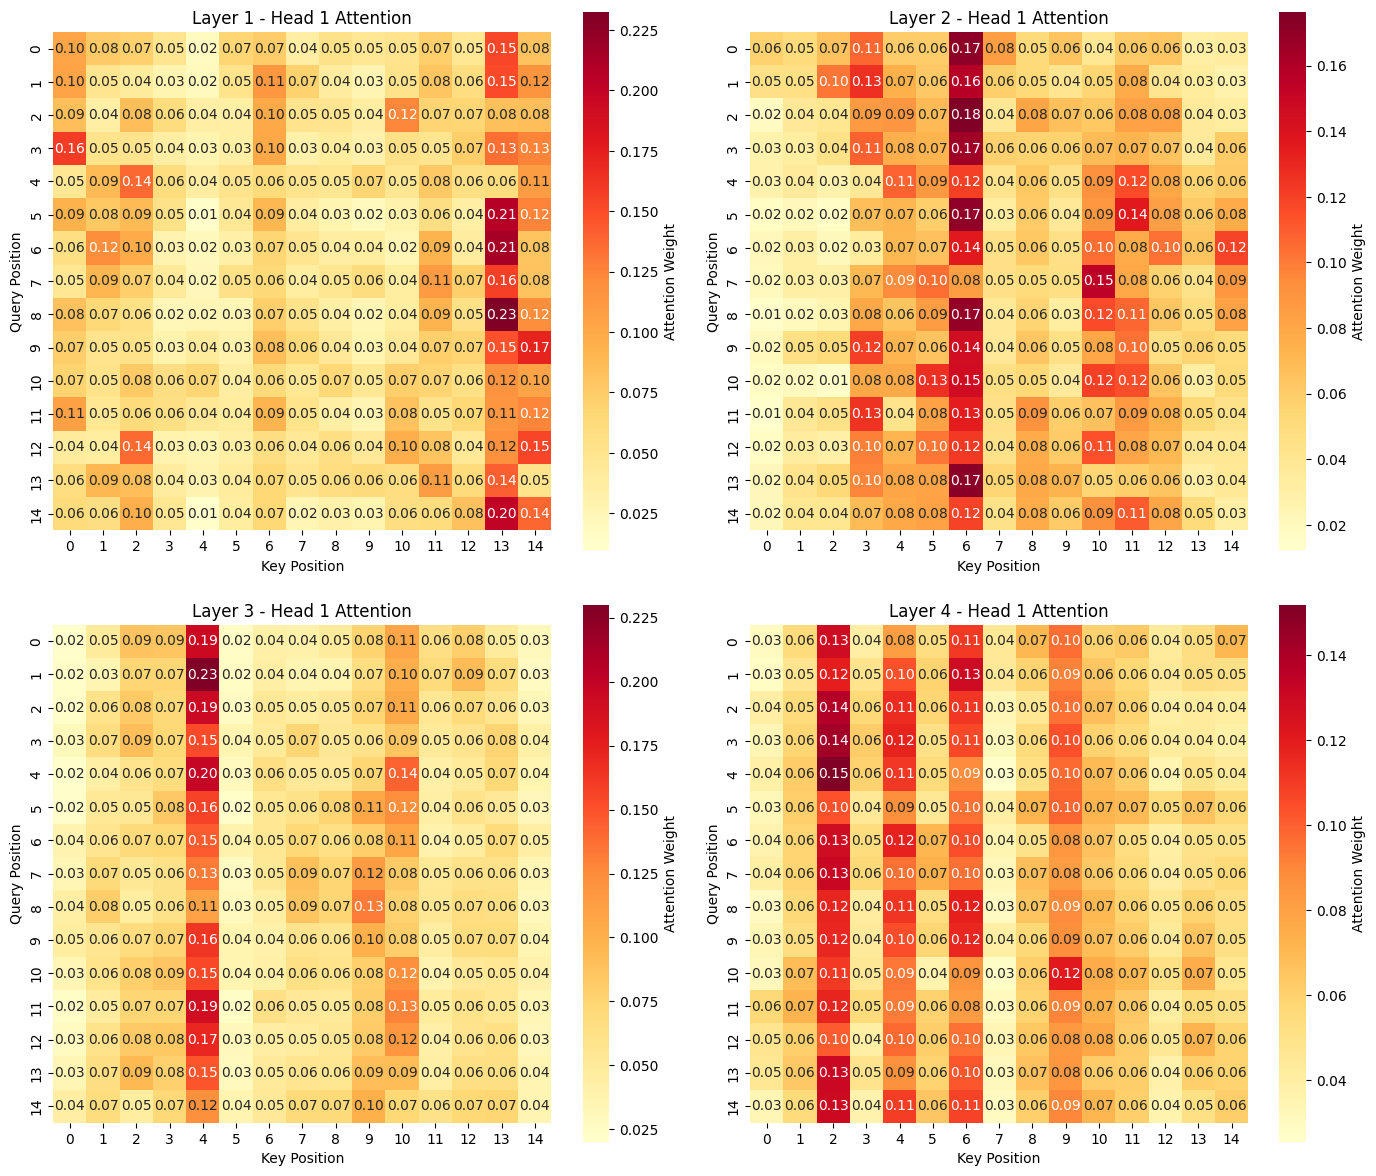

In [7]:
# Generate a single sequence for visualization
model.eval()
with torch.no_grad():
    test_seq = torch.randint(0, vocab_size, (1, 15)).to(device)
    _, _, attention_weights = model(test_seq)

# Visualize attention from first layer, first head
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for layer_idx in range(min(4, len(attention_weights))):
    # Get attention weights for first head
    attn = attention_weights[layer_idx][0, 0].cpu().numpy()  # (seq_len, seq_len)
    
    sns.heatmap(attn, annot=True, fmt='.2f', cmap='YlOrRd', 
                square=True, ax=axes[layer_idx],
                cbar_kws={'label': 'Attention Weight'})
    axes[layer_idx].set_title(f'Layer {layer_idx + 1} - Head 1 Attention')
    axes[layer_idx].set_xlabel('Key Position')
    axes[layer_idx].set_ylabel('Query Position')

plt.tight_layout()
plt.show()

## 8. Training Example: Sequence Modeling

Let's train the model on a simple sequence prediction task.

In [8]:
# Create a simple synthetic dataset
# Task: Predict the next token in a sequence
torch.manual_seed(42)

def generate_synthetic_data(num_samples, seq_len, vocab_size):
    """Generate synthetic sequential data."""
    # Create sequences where next token is related to previous tokens
    data = []
    for _ in range(num_samples):
        # Generate random sequence
        seq = torch.randint(0, vocab_size // 2, (seq_len,))
        # Target is shifted sequence (next token prediction)
        target = torch.cat([seq[1:], torch.tensor([seq[-1] + 1])])
        data.append((seq, target))
    return data

# Generate dataset
num_samples = 500
seq_len = 20
vocab_size = 100
dataset = generate_synthetic_data(num_samples, seq_len, vocab_size)

# Create a smaller model for training
small_model = TransformerMoE(
    vocab_size=vocab_size,
    d_model=64,
    num_heads=4,
    d_ff=256,
    num_layers=2,
    num_experts=4,
    top_k=2,
    dropout=0.1
).to(device)

# Training setup
optimizer = torch.optim.AdamW(small_model.parameters(), lr=0.0001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
aux_loss_weight = 0.01

# Training loop
num_epochs = 30
batch_size = 32
losses = []
aux_losses = []

small_model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_aux_loss = 0.0
    num_batches = 0
    
    # Shuffle dataset
    indices = torch.randperm(len(dataset))
    
    for i in range(0, len(dataset), batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_seqs = torch.stack([dataset[idx][0] for idx in batch_indices]).to(device)
        batch_targets = torch.stack([dataset[idx][1] for idx in batch_indices]).to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits, aux_loss, _ = small_model(batch_seqs)
        
        # Compute loss
        classification_loss = criterion(logits.view(-1, vocab_size), batch_targets.view(-1))
        total_loss = classification_loss + aux_loss_weight * aux_loss
        
        # Backward pass
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(small_model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += classification_loss.item()
        epoch_aux_loss += aux_loss.item()
        num_batches += 1
    
    epoch_loss /= num_batches
    epoch_aux_loss /= num_batches
    losses.append(epoch_loss)
    aux_losses.append(epoch_aux_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Aux Loss: {epoch_aux_loss:.4f}")

print("\nTraining completed!")

Epoch [5/30], Loss: 4.2741, Aux Loss: 3.3446
Epoch [10/30], Loss: 4.0892, Aux Loss: 3.5972
Epoch [15/30], Loss: 4.0116, Aux Loss: 3.6032
Epoch [20/30], Loss: 3.9604, Aux Loss: 3.5081
Epoch [25/30], Loss: 3.9106, Aux Loss: 3.2866
Epoch [30/30], Loss: 3.8550, Aux Loss: 3.0787

Training completed!


## 9. Visualize Training Progress

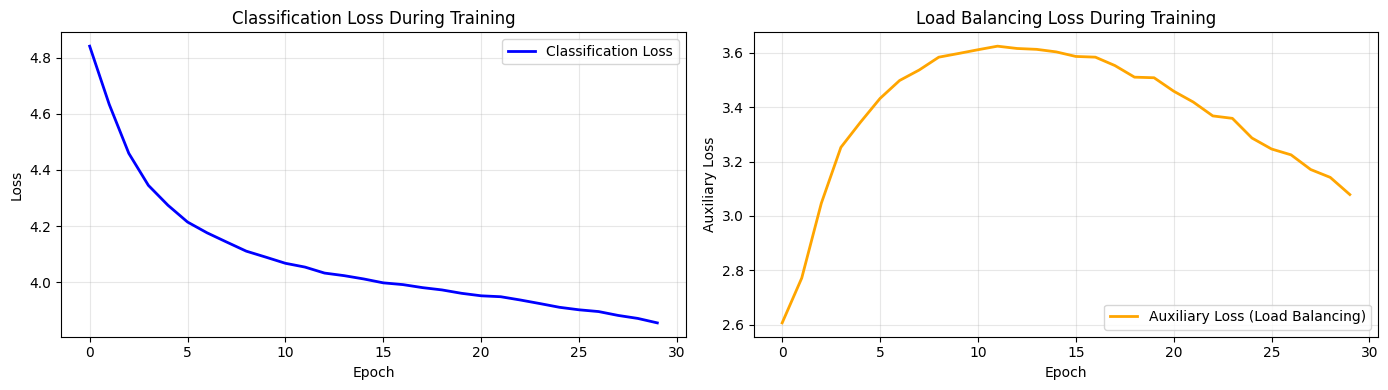


Model Accuracy: 6.85%
Total parameters: 311,916


In [9]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Classification loss
ax1.plot(losses, label='Classification Loss', color='blue', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Classification Loss During Training')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Auxiliary loss
ax2.plot(aux_losses, label='Auxiliary Loss (Load Balancing)', color='orange', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Auxiliary Loss')
ax2.set_title('Load Balancing Loss During Training')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate model
small_model.eval()
total_correct = 0
total_tokens = 0

with torch.no_grad():
    for seq, target in dataset[:100]:  # Evaluate on first 100 samples
        seq = seq.unsqueeze(0).to(device)
        target = target.to(device)
        
        logits, _, _ = small_model(seq)
        predictions = torch.argmax(logits[0], dim=-1)
        
        total_correct += (predictions == target).sum().item()
        total_tokens += target.size(0)

accuracy = total_correct / total_tokens
print(f"\nModel Accuracy: {accuracy*100:.2f}%")
print(f"Total parameters: {sum(p.numel() for p in small_model.parameters()):,}")

## 10. Model Inference and Visualization

Sample Sequence Prediction:
Input:       [42, 17, 26, 14, 26, 35, 20, 24, 0, 13]...
Target:      [17, 26, 14, 26, 35, 20, 24, 0, 13, 28]...
Predictions: [17, 18, 36, 29, 13, 17, 13, 48, 14, 28]...

Matches: 4 / 20


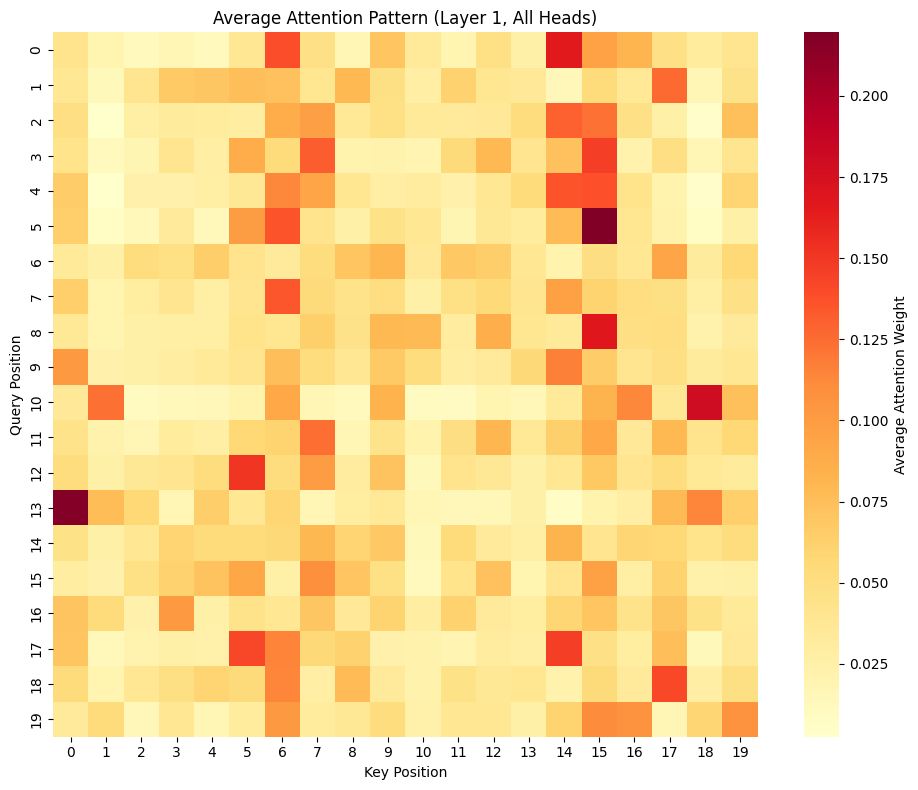

In [10]:
# Test the model on a sample sequence
small_model.eval()
test_seq, test_target = dataset[0]
test_seq_batch = test_seq.unsqueeze(0).to(device)

with torch.no_grad():
    logits, aux_loss, attention_weights = small_model(test_seq_batch)
    predictions = torch.argmax(logits[0], dim=-1).cpu()

# Print results
print("Sample Sequence Prediction:")
print(f"Input:       {test_seq.tolist()[:10]}...")
print(f"Target:      {test_target.tolist()[:10]}...")
print(f"Predictions: {predictions.tolist()[:10]}...")
print(f"\nMatches: {(predictions == test_target).sum().item()} / {len(test_target)}")

# Visualize attention pattern for this sequence
plt.figure(figsize=(10, 8))
# Average attention across all heads for first layer
avg_attention = attention_weights[0][0].mean(dim=0).cpu().numpy()
sns.heatmap(avg_attention, cmap='YlOrRd', square=True,
            cbar_kws={'label': 'Average Attention Weight'})
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Average Attention Pattern (Layer 1, All Heads)')
plt.tight_layout()
plt.show()

## Summary

In this notebook, we implemented a complete Transformer architecture with the following components:

### 1. **Input Embeddings and Positional Encoding**
   - Token embeddings convert discrete tokens to continuous vectors
   - Sinusoidal positional encodings add position information
   - Scaling by √d_model for better training dynamics

### 2. **Multi-Head Attention**
   - Scaled dot-product attention mechanism
   - Multiple attention heads for different representation subspaces
   - Allows model to attend to different positions simultaneously

### 3. **Mixture of Experts (MoE)**
   - Replaces standard feed-forward network
   - Multiple expert networks with specialized capabilities
   - Top-K routing for efficient sparse activation
   - Load balancing loss for uniform expert usage

### 4. **Residual Connections**
   - Skip connections around attention and feed-forward layers
   - Enables training of very deep networks
   - Helps with gradient flow

### 5. **Layer Normalization**
   - Applied after residual connections
   - Stabilizes training
   - Improves convergence

### Key Advantages of This Architecture:

- **Scalability**: MoE allows scaling to billions of parameters while keeping computation constant
- **Efficiency**: Sparse activation through Top-K routing
- **Specialization**: Different experts can learn different patterns
- **Parallelism**: Attention and expert computation can be parallelized
- **Flexibility**: Can be adapted for various sequence modeling tasks

### Practical Applications:

- Language modeling and text generation
- Machine translation
- Document understanding
- Code generation
- Time series forecasting
- Any sequential data processing task

This architecture combines the best aspects of modern Transformers with the scalability benefits of Mixture of Experts, making it suitable for large-scale applications.